In [1]:
#Cài đặt thư viện 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
import statsmodels.api as sm
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU,  Dropout

In [2]:
#2. Đọc file dữ liệu và xem dữ liệu
df = pd.read_csv('../GoldData.csv',parse_dates=True)
df1=df.reset_index()['Lần cuối']

In [3]:
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,21/5/2018,1290.9,1290.3,1292.7,1281.2,328.02K
1,22/5/2018,1292.0,1292.3,1296.0,1287.2,291.72K
2,23/5/2018,1289.6,1290.6,1298.4,1286.7,402.34K
3,24/5/2018,1304.4,1293.3,1306.4,1292.2,432.42K
4,25/5/2018,1303.7,1304.0,1307.2,1299.4,292.91K
...,...,...,...,...,...,...
1291,15/5/2023,2018.0,2013.8,2017.1,2013.8,0.00K
1292,16/5/2023,1988.4,2021.3,2022.7,1989.1,0.05K
1293,17/5/2023,1980.7,1983.6,1983.6,1983.6,0.01K
1294,18/5/2023,1956.5,1956.8,1956.8,1956.8,0.02K


In [4]:
df1

0       1290.9
1       1292.0
2       1289.6
3       1304.4
4       1303.7
         ...  
1291    2018.0
1292    1988.4
1293    1980.7
1294    1956.5
1295    1978.7
Name: Lần cuối, Length: 1296, dtype: float64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler()
df=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test val theo tỉ lệ 7-2-1
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+39 and Y=t+40
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=50,verbose=1,shuffle=False)

Epoch 1/50


15/15 [==============================] - 3s 64ms/step - loss: 0.0319 - val_loss: 0.0053
Epoch 2/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0382 - val_loss: 0.0062
Epoch 3/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0163 - val_loss: 0.0026
Epoch 4/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0090 - val_loss: 0.0010
Epoch 5/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 8.4942e-04
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 7/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0062 - val_loss: 8.2814e-04
Epoch 8/50
15/15 [==============================] - 0s 23ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 9/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0062 - val_loss: 7.0508e-04
Epoch 10/50
15/15 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 11

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 4ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
yval=scaler.inverse_transform(yval.reshape(-1,1))

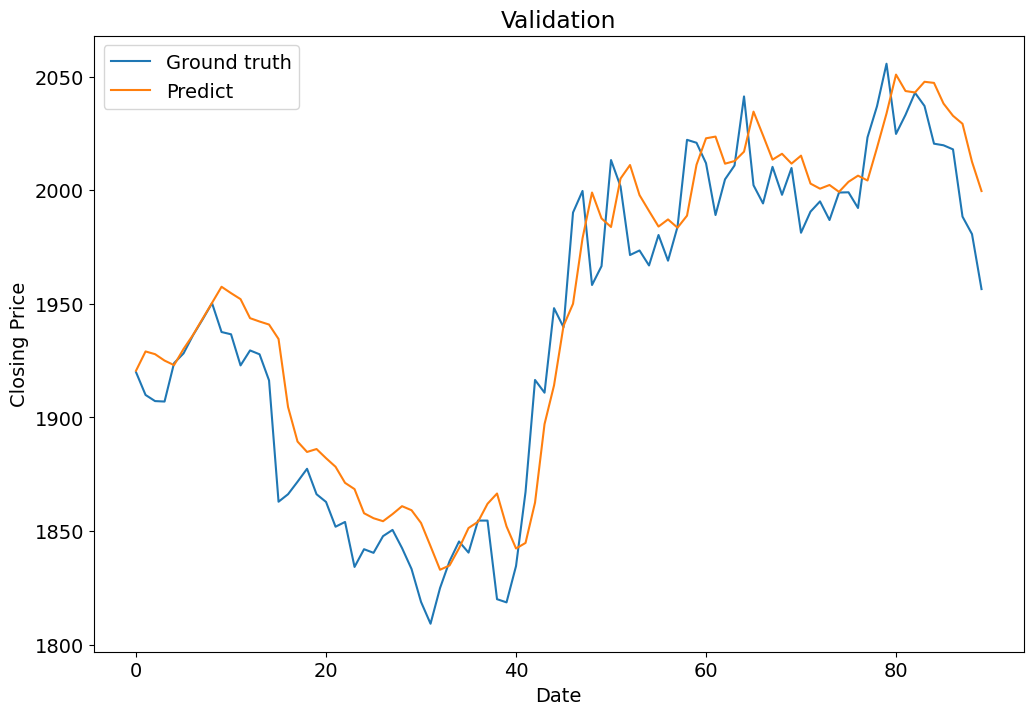

In [15]:
plt.figure(figsize=(12,8))
plt.plot(yval, label = 'Ground truth')
plt.plot(y_pred_val, label='Predict')
plt.title("Validation")
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

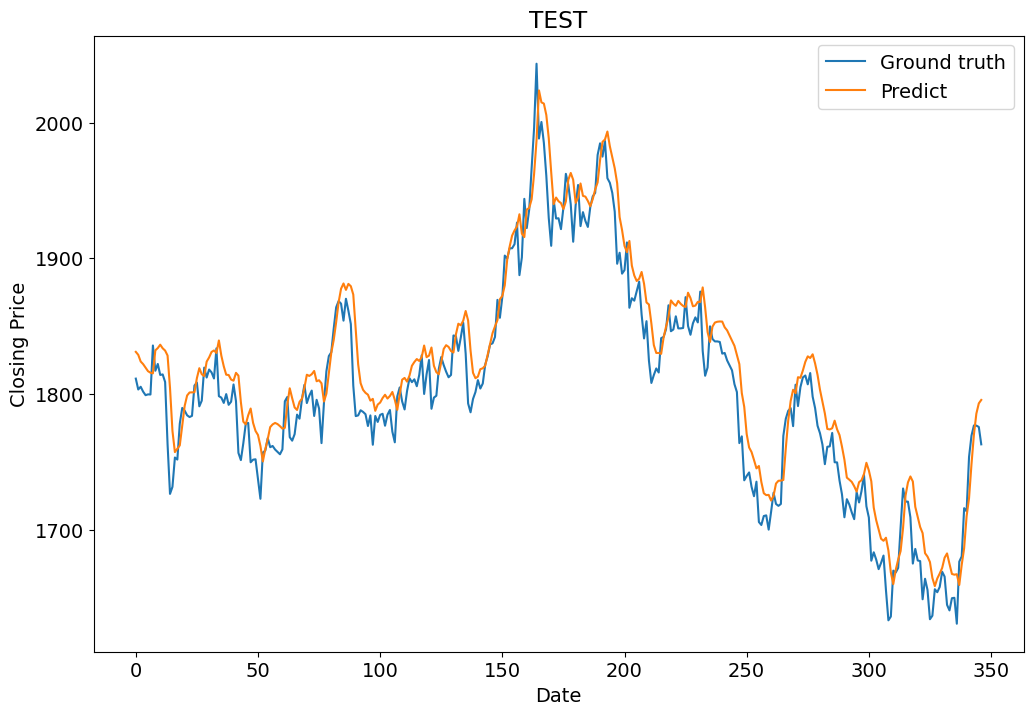

In [16]:
plt.figure(figsize=(12,8))
plt.plot(ytest, label = 'Ground truth')
plt.plot(y_pred, label='Predict')
plt.title("TEST")
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [17]:
#Tính độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(yval))  # MAPE
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(ytest))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,yval) # MAE
test_mae = mean_absolute_error(y_pred,ytest)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Validation MAE: {valid_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")



Validation RMSE: 23.38
Testing RMSE: 24.66
Validation MAPE: 0.97%
Testing MAPE: 1.12%
Validation MAE: 18.65
Testing MAE: 19.96


In [18]:

val_len=len(val_data)
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=val_len-60
i=0
while(i<30):
        
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.9022562]
72
1 day input [0.75434832 0.75672013 0.73435735 0.74316693 0.74135984 0.74966117
 0.75276711 0.74373165 0.73334086 0.71696408 0.70612153 0.72385363
 0.73718094 0.747007   0.74147278 0.75739779 0.75739779 0.7183194
 0.7167382  0.73480913 0.77162864 0.82730969 0.82098487 0.86299977
 0.85351254 0.9105489  0.92127852 0.87451999 0.88389429 0.93663881
 0.92353738 0.88942851 0.89168737 0.88423311 0.89936752 0.88660492
 0.90343348 0.94669076 0.9452225  0.9350576  0.90930653 0.92703863
 0.93392817 0.96826293 0.9241021  0.91506664 0.93325051 0.91935848
 0.93268579 0.90049695 0.91100068 0.91608313 0.90682178 0.92048792
 0.92060086 0.91280777 0.94793314 0.96340637 0.98452677 0.94962729
 0.95911452 0.97007002 0.96351931 0.94477073 0.94398012 0.94194714
 0.90851593 0.89981929 0.87248701 0.89756042 0.90225619]
1 day output [[0.90695196]]
2 day input [0.75672013 0.73435735 0.74316693 0.74135984 0.74966117 0.75276711
 0.74373165 0.73334086 0.71696408 0.70612153 0.72385363 0.73718094
 0.747

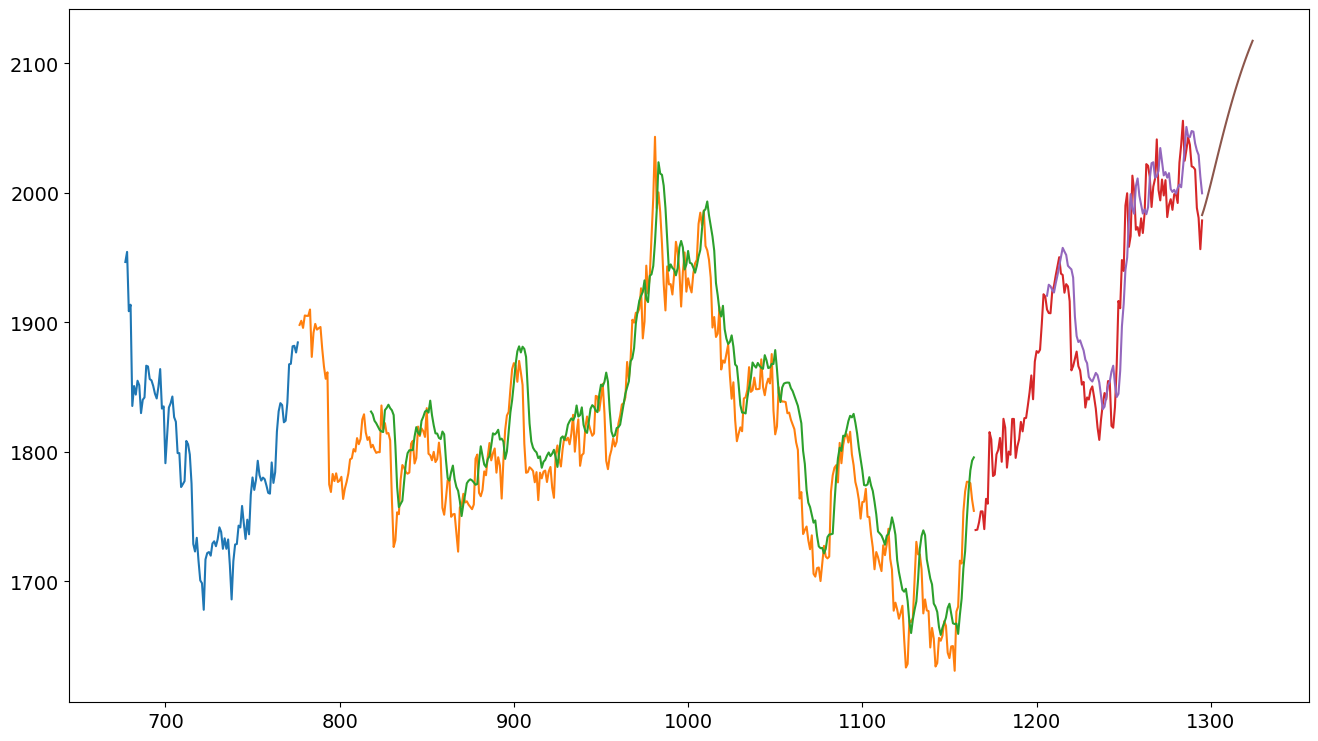

In [19]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=train_size-100, stop=train_size, step=1)
plt.plot(train_data_index,scaler.inverse_transform(train_data[train_size-100:]))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))